In [1]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [8]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [25]:
#!mkdir ../yaml/august-16-2022
#!mkdir ../output/august-16-2022

In [22]:
# simulation parameters
time_limit = 500
time_step = 5
transcript_lens = [300, 300]
cellular_transcript_copy_number = 50
transgene_transcript_copy_numbers = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 300, 500]
ribosome_copy_number = 100
total_trna = 1000
ribosome_binding_rates = [100000.0, 100000.0]
trna_charging_rate = 100.0
transcript_names = ["cellularProtein", "GFP"]
trna_props = [(0.6, 0.4), (0.9, 0.1), (0.95, 0.05)]
#codon_comps_1 = (0.9, 0.1)
codon_comps_2 = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]

date = "august-16-2022"

In [23]:
for trna_prop in trna_props:
    for comp in codon_comps_2:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[trna_prop, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [24]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for transgene_copy in transgene_transcript_copy_numbers:
            for seed in range(1, 4):
                cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {transgene_copy} " + \
                  f"{ribosome_copy_number} {total_trna} {ribosome_binding_rates[0]} {ribosome_binding_rates[1]} {trna_charging_rate} {trna_charging_rate} ../output/{date}"
                stream.write(cmd)
                stream.write("\n")

In [26]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = pd.read_csv(f"{path}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    if tmp.empty:
        times = df_master["time"].to_list()
        dedup_times = []
        [dedup_times.append(x) for x in times if x not in dedup_times]
        next_best_time = take_closest(dedup_times, time)
        tmp = df_master.loc[df_master['time'] == next_best_time].groupby(["species"])["protein"].mean().reset_index()
    #tmp["codon_comp"] = perc_good
    return tmp

In [29]:
df_master = None
for trna_prop in trna_props:
    df_trna = None
    for codon_comp in codon_comps_2:
        df_codon = None
        for transgene_copy in transgene_transcript_copy_numbers:
            path = f"../output/{date}/two_codon_multi_transcript_{trna_prop[0]}_{trna_prop[1]}_{codon_comp[0]}_{codon_comp[1]}_{trna_prop[0]}_{trna_prop[1]}" + \
                   f"_{cellular_transcript_copy_number}_{transgene_copy}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ribosome_binding_rates[0]}_{ribosome_binding_rates[1]}_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 500, 3)
            tmp["transgene_copy"] = transgene_copy
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_codon is not None:
                df_codon = df_codon.append(tmp, ignore_index=True)
            else:
                df_codon = tmp
            df_codon["codon_comp"] = codon_comp[0]
        if df_trna is not None:
            df_trna = df_trna.append(df_codon, ignore_index=True)
        else:
            df_trna = df_codon
        df_trna["trna_prop"] = trna_prop[0]
    if df_master is not None:
        df_master = df_master.append(df_trna, ignore_index=True)
    else:
        df_master = df_trna

df_master

,species,protein,transgene_copy,codon_comp,trna_prop
0,ATA_charged,357.000000,0,0.9,0.60
1,ATA_uncharged,43.000000,0,0.9,0.60
2,TTT_charged,532.000000,0,0.9,0.60
3,TTT_uncharged,68.000000,0,0.9,0.60
4,__cellularProtein_rbs,50.000000,0,0.9,0.60
...,...,...,...,...,...
1990,TTT_uncharged,4.000000,500,0.1,0.95
1991,__GFP_rbs,497.333333,500,0.1,0.95
1992,__cellularProtein_rbs,50.000000,500,0.1,0.95
1993,free ribosome,0.000000,500,0.1,0.95


In [31]:
pivot = df_master.pivot(index = ["codon_comp", "transgene_copy", "trna_prop"], columns = "species", values = "protein").reset_index()
pivot["GFP"] = pivot["GFP"].fillna(0)
#pivot["cellularProtein_transformed"] = pivot["cellularProtein"] / pivot["cellularProtein"].max()
pivot["cellularProtein_transformed"] = pivot["cellularProtein"].groupby([pivot.codon_comp, pivot.trna_prop]).transform(lambda x: x/x.max())
pivot["GFP_transformed"] = pivot["GFP"] / (pivot["GFP"] + pivot["cellularProtein"])
pivot["Percent_opt"] = (pivot["codon_comp"] / pivot["trna_prop"] * 100).round().astype("int")
pivot["exp_cellularProtein"] = np.exp(pivot["cellularProtein_transformed"])
pivot

species,codon_comp,transgene_copy,trna_prop,ATA_charged,ATA_uncharged,GFP,TTT_charged,TTT_uncharged,__GFP_rbs,__cellularProtein_rbs,cellularProtein,free ribosome,cellularProtein_transformed,GFP_transformed,Percent_opt,exp_cellularProtein
0,0.1,0,0.60,357.000000,43.000000,0.000000,532.000000,68.000000,NaN,50.000000,18917.000000,76.000000,1.000000,0.000000,17,2.718282
1,0.1,0,0.90,87.666667,12.333333,0.000000,801.333333,98.666667,NaN,48.666667,18915.666667,75.666667,1.000000,0.000000,11,2.718282
2,0.1,0,0.95,44.000000,6.000000,0.000000,843.333333,106.666667,NaN,49.000000,18737.333333,74.000000,1.000000,0.000000,11,2.718282
3,0.1,10,0.60,358.000000,42.000000,766.333333,539.333333,60.666667,10.000000,50.000000,18693.000000,75.666667,0.988159,0.039381,17,2.686284
4,0.1,10,0.90,82.000000,18.000000,730.000000,814.333333,85.666667,9.666667,49.666667,17914.333333,72.666667,0.947063,0.039154,11,2.578127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0.9,300,0.90,69.333333,30.666667,51799.333333,602.666667,297.333333,297.666667,50.000000,1459.000000,5.333333,0.077132,0.972605,100,1.080184
221,0.9,300,0.95,30.666667,19.333333,34056.666667,745.333333,204.666667,297.000000,50.000000,937.666667,2.000000,0.050043,0.973205,95,1.051316
222,0.9,500,0.60,361.666667,38.333333,51950.333333,313.333333,286.666667,499.333333,50.000000,522.333333,3.000000,0.027612,0.990046,150,1.027997
223,0.9,500,0.90,68.000000,32.000000,54069.000000,586.000000,314.000000,497.000000,50.000000,549.000000,2.000000,0.029024,0.989948,100,1.029449


In [32]:
rcParams['figure.figsize'] = [8, 6]

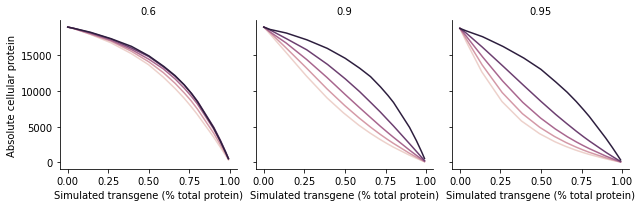

In [33]:
g = sns.FacetGrid(pivot, col="trna_prop", col_wrap=3, sharey=True)
g.map_dataframe(sns.lineplot, "GFP_transformed", "cellularProtein", hue="Percent_opt")
g.set_titles("{col_name}")
g.set_axis_labels("Simulated transgene (% total protein)", "Absolute cellular protein")  

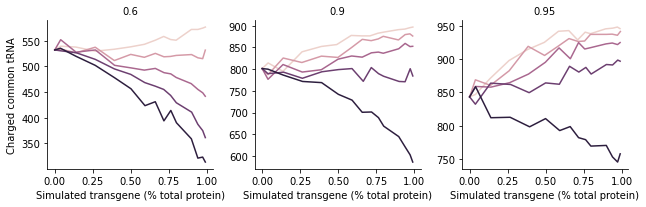

In [35]:
g = sns.FacetGrid(pivot, col="trna_prop", col_wrap=3, sharey=False)
g.map_dataframe(sns.lineplot, "GFP_transformed", "TTT_charged", hue = "Percent_opt")
g.set_titles("{col_name}")
g.set_axis_labels("Simulated transgene (% total protein)", "Charged common tRNA")  

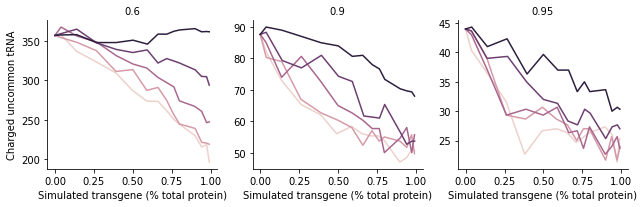

In [36]:
g = sns.FacetGrid(pivot, col="trna_prop", col_wrap=3, sharey=False)
g.map_dataframe(sns.lineplot, "GFP_transformed", "ATA_charged", hue = "Percent_opt")
g.set_titles("{col_name}")
g.set_axis_labels("Simulated transgene (% total protein)", "Charged uncommon tRNA")  

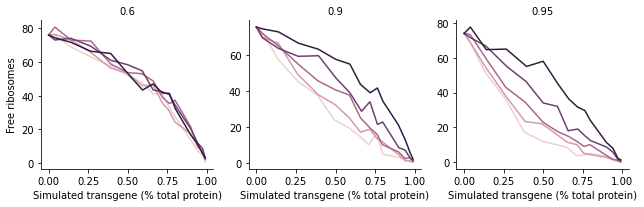

In [38]:
g = sns.FacetGrid(pivot, col="trna_prop", col_wrap=3, sharey=False)
g.map_dataframe(sns.lineplot, "GFP_transformed", "free ribosome", hue = "Percent_opt")
g.set_titles("{col_name}")
g.set_axis_labels("Simulated transgene (% total protein)", "Free ribosomes")  